In [19]:
#####################
# NLP + ANN
#####################

import numpy as np
import pandas as pd
import os
import re
import math

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler

import tensorflow as tf
# from tensorflow import keras
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Flatten, LSTM,Input, Dropout, Embedding
from tensorflow.keras.layers import GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate
from tensorflow.keras.callbacks import EarlyStopping, Callback
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot, Tokenizer

pd.options.display.max_colwidth = 100

SEED = 42
TEST_SIZE = 0.2

callback = EarlyStopping(monitor='loss', patience=3)

p_data_raw       = os.path.abspath('../data/raw') # raw data path
p_data_processed = os.path.abspath('../data/processed') # processed data path
p_data_cleaned   = os.path.abspath('../data/cleaned') # clearned data path
p_data_src       = os.path.abspath('../data/src') # src data path

k_ratings_f = pd.read_csv(os.path.abspath('../data/k_ratings_f.csv'), dtype={'label_c': object})
k_ratings_f_w_tag = pd.read_csv(os.path.abspath('../data/k_ratings_f_w_tag.csv'), dtype={'label_c': object})

In [20]:
X = pd.concat([k_ratings_f.drop(['userId','movieId','rating_x','timestamp','name','year','rating_y',
                                 # 'metascore',
                                 'imdb_id','poster','genre',
                                 'certificate','runtime','director_actor', 
                                 # 'story', 
                                 'imdbId','tmdbId',
                                 'title','genres','genre1',
                                 'label','label_c',
                                 'y_5','y',
                                 # 'timestamp','vote',
                                 'director','director1','director2','actor1'
                                 ], axis = 1),
               pd.get_dummies(k_ratings_f[[
                   #'certificate',
                   #'genre1',
                   'label_c','director1','actor1']], 
                              drop_first = True, dummy_na = True)],axis = 1)

# y = k_ratings_f_w_tag['y_5']
y = k_ratings_f['y']

# y = k_ratings_f_w_tag['y'].cat.codes

# fill metascore null values with mean
X['metascore'].fillna(X['metascore'].mean(), inplace=True)
X.fillna(0,inplace=True)

In [21]:
# label_encoder object knows how to understand word labels.
label_encoder = preprocessing.LabelEncoder()

# Encode target labels.
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = TEST_SIZE, random_state = SEED)

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [57]:
#############################
# NLP
#############################

def preprocess_text(sen):
    # Remove punctuations and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sen)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)            
    # Removing "See full summary »"
    sentence = sentence.replace('See full summary', ' ')
    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

X1_train = []
sentences = list(X_train["story"])
for sen in sentences:
    X1_train.append(preprocess_text(sen))
    
X1_test = []
sentences = list(X_test["story"])
for sen in sentences:
    X1_test.append(preprocess_text(sen))
    
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X1_train)

X1_train = tokenizer.texts_to_sequences(X1_train)
X1_test = tokenizer.texts_to_sequences(X1_test)

vocab_size = len(tokenizer.word_index) + 1

maxlen = 50 # 200

X1_train = pad_sequences(X1_train, padding='post', maxlen=maxlen)
X1_test = pad_sequences(X1_test, padding='post', maxlen=maxlen)

# data scale
# scaler1 = MinMaxScaler()
scaler1 = StandardScaler()
X1_train = scaler1.fit_transform(X1_train)
X1_test = scaler1.transform(X1_test)

# embedding

embeddings_dictionary = dict()

glove_file_link = p_data_src+'/glove.6B/glove.6B.50d.txt' # glove file link

with open(glove_file_link, 'r') as glove_file:
    for line in glove_file:
        records = line.split()
        word = records[0]
        vector_dimensions = asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

glove_file.close()

embedding_matrix = np.zeros((vocab_size, 50))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [58]:
###############
# ANN
###############

X2_train = X_train.drop('story', axis=1).copy().values
X2_test = X_test.drop('story', axis=1).copy().values

# data scale
# scaler2 = MinMaxScaler()
scaler2 = StandardScaler()
X2_train = scaler2.fit_transform(X2_train)
X2_test = scaler2.transform(X2_test)

In [59]:
################
# merge model
################

input_1 = Input(shape=(maxlen,))
input_2 = Input(shape=(X.shape[1]-1,))

embedding_layer = Embedding(vocab_size, 50, weights=[embedding_matrix], trainable=False)(input_1)
LSTM_Layer_1 = LSTM(128)(embedding_layer)

In [60]:
# create model
def create_model():
    
    tf.keras.backend.clear_session()
    
    dense_layer_1 = Dense(972, activation='relu')(input_2)
    dense_layer_2 = Dense(1944, activation='relu')(dense_layer_1)
    dense_layer_3 = Dense(972, activation='relu')(dense_layer_2)
    dense_layer_4 = Dense(486, activation='relu')(dense_layer_3)
    dense_layer_5 = Dense(243, activation='relu')(dense_layer_4)    
    
    concat_layer = Concatenate()([LSTM_Layer_1, dense_layer_5])
    dense_layer_6 = Dense(10, activation='relu')(concat_layer)
    # output = Dense(5, activation='softmax')(dense_layer_6)
    output = Dense(3, activation='softmax')(dense_layer_6)
    
    model = Model(inputs=[input_1, input_2], outputs=output)
    
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(model.summary())
    #plot_model(model, to_file='figures/model_plot_final.png', show_shapes=True, show_layer_names=True)

    return model

model=create_model()
history = model.fit(x=[X1_train, X2_train], y=y_train, validation_data=([X1_test, X2_test],y_test),
                    callbacks=[callback],
                    batch_size=128, epochs=100, verbose=1)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 486)]        0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 972)          473364      input_2[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 1944)         1891512     dense[0][0]                      
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 50)]         0                                            
______________________________________________________________________________________________

In [62]:
score = model.evaluate(x=[X1_test, X2_test], y=y_test, verbose=1)

print("Test Score:", score[0])
print("Test Accuracy:", score[1])

6456/6456 [==============================] - 4s 543us/sample - loss: 0.8169 - accuracy: 0.7116
Test Score: 0.8169393091101333
Test Accuracy: 0.7115861


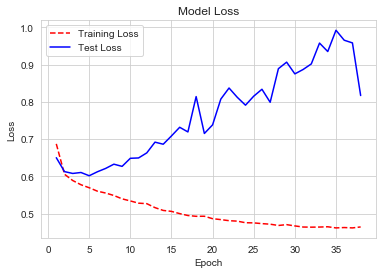

<Figure size 432x288 with 0 Axes>

In [63]:
# Get training and test loss histories
training_loss = model.history.history['loss']
test_loss = model.history.history['val_loss']

# Create count of the number of epochs
epoch_count = range(1, len(training_loss) + 1)

# Visualize loss history
# plt.ylim(top=1.02)
# plt.ylim(bottom=0.68)

plt.plot(epoch_count, training_loss, 'r--')
plt.plot(epoch_count, test_loss, 'b-')
plt.legend(['Training Loss', 'Test Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.show()
plt.savefig(os.path.abspath('figures/Model_Loss.png'))

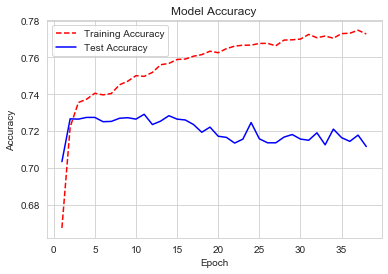

<Figure size 432x288 with 0 Axes>

In [64]:
# Get training and test accuracy histories
training_accuracy = model.history.history['accuracy']
test_accuracy = model.history.history['val_accuracy']

# Create count of the number of epochs
epoch_count = range(1, len(training_accuracy) + 1)

# Visualize loss history
plt.plot(epoch_count, training_accuracy, 'r--')
plt.plot(epoch_count, test_accuracy, 'b-')
plt.legend(['Training Accuracy', 'Test Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.show()
plt.savefig(os.path.abspath('figures/Model_Accuracy.png'))

In [ ]:
# cross_validation?

In [61]:
########################
# final model
########################

# model=create_model()
# history = model.fit(x=[X1_train, X2_train], y=y_train, validation_data=([X1_test, X2_test],y_test),
#                     callbacks=[callback],
#                     batch_size=128, epochs=100, verbose=1)

In [65]:
# save model
model.save("final_model_traindata_final.h5")

import joblib
joblib.dump(scaler1,'scaler1.pkl')
joblib.dump(scaler2,'scaler2.pkl')

['scaler2.pkl']

In [8]:
# load model
import joblib
from tensorflow.keras.models import load_model
ratings_model = load_model('final_model_traindata_final.h5')
ratings_scaler1 = joblib.load('scaler1.pkl')
ratings_scaler2 = joblib.load('scaler2.pkl')

In [ ]:
#####################################

In [64]:
reviewers_mat = k_ratings_f[['userId','label','label_c']].copy()
movies_mat = k_ratings_f.drop(['userId','rating_x','timestamp','label','label_c','y','y_5'], axis=1).copy()
# movies_mat = k_ratings_f.drop(['userId','rating_x','timestamp','label','label_c','story'], axis=1).copy()
# storys_mat = k_ratings_f[['movieId','story']].copy()

reviewers_mat = reviewers_mat.drop_duplicates(subset='userId')
movies_mat = movies_mat.drop_duplicates(subset='movieId')
# storys_mat = storys_mat.drop_duplicates(subset='movieId')

print('# reviewers: {}'.format(len(reviewers_mat)))
print('# movies: {}'.format(len(movies_mat)))

# reviewers: 9782
# movies: 353


In [65]:
# create megamat
reviewers_mat['joincol'] = 1
movies_mat['joincol'] = 1
megamat = pd.merge(reviewers_mat,movies_mat,how='outer',on='joincol')
print(len(megamat))

3453046


In [66]:
# exclude ratings with real "y"
k_ratings_f['joinId'] = k_ratings_f['userId'].astype(str) + '_' + k_ratings_f['movieId'].astype(str)

In [67]:
# take long time!
megamat['joinId'] = megamat['userId'].astype(str) + '_' + megamat['movieId'].astype(str)

In [68]:
megamat = megamat[~megamat.joinId.isin(k_ratings_f['joinId'].tolist())]
print(len(megamat))

3420768


In [43]:
megamat.head()

,userId,label,label_c,joincol,movieId,name,year,rating_y,metascore,vote,...,title,genres,genre1,year_n,runtime_n,director,director1,director2,actor1,joinId
9,181,34,34,1,30803,3-Iron,(2004),8.0,72.0,47924.0,...,3-Iron (Bin-jip) (2004),Drama|Romance,Drama,2004,88,Kiduk Kim,KidukKim,NaN,SeungYunLee,181_30803
10,181,34,34,1,27869,Tae Guk Gi: The Brotherhood of War,(2004),8.1,64.0,37060.0,...,Tae Guk Gi: The Brotherhood of War (Taegukgi hwinalrimyeo) (2004),Action|Drama|War,Action,2004,140,Jekyu Kang,JekyuKang,NaN,DongGunJang,181_27869
11,181,34,34,1,31364,Memories of Murder,(2003),8.1,82.0,123625.0,...,Memories of Murder (Salinui chueok) (2003),Crime|Drama|Mystery|Thriller,Crime,2003,132,Bong Joon Ho,BongJoonHo,NaN,KanghoSong,181_31364
12,181,34,34,1,6210,Hwasango,(2001),6.0,NaN,3329.0,...,Volcano High (Whasango) (2001),Action|Comedy,Action,2001,120,Taegyun Kim,TaegyunKim,NaN,HyukJang,181_6210
13,181,34,34,1,76091,Mother,(2009),7.8,79.0,46913.0,...,Mother (Madeo) (2009),Crime|Drama|Mystery|Thriller,Crime,2009,129,Bong Joon Ho,BongJoonHo,NaN,HyejaKim,181_76091


In [69]:
X = pd.concat([megamat.drop(['joincol','joinId','userId','movieId','name','year','rating_y',
                                 # 'metascore',
                                 'imdb_id','poster','genre',
                                 'certificate','runtime','director_actor', 
                                 # 'story', 
                                 'imdbId','tmdbId',
                                 'title','genres','genre1',
                                 'label','label_c',
                                 # 'timestamp','vote',
                                 'director','director1','director2','actor1'
                                 ], axis = 1),
               pd.get_dummies(megamat[[
                   #'certificate',
                   #'genre1',
                   'label_c','director1','actor1']], 
                              drop_first = True, dummy_na = True)],axis = 1)

# fill metascore null values with mean
X['metascore'].fillna(X['metascore'].mean(), inplace=True)
X.fillna(0,inplace=True)

In [67]:
k_ratings_f

,userId,movieId,rating_x,timestamp,name,year,rating_y,metascore,vote,imdb_id,...,year_n,runtime_n,label,label_c,y_5,y,director,director1,director2,actor1
0,181,8014,1.5,1547804302,"Spring, Summer, Fall, Winter... and Spring",(2003),8.0,85.0,74747.0,tt0374546,...,2003,103,34,34,2,1,Kiduk Kim,KidukKim,NaN,KidukKim
1,181,27773,3.5,1547803413,Oldboy,(2003),8.4,77.0,494073.0,tt0364569,...,2003,120,34,34,4,1,Chanwook Park,ChanwookPark,NaN,MinsikChoi
2,181,107406,1.0,1547806302,Snowpiercer,(2013),7.1,84.0,292313.0,tt1706620,...,2013,126,34,34,1,0,Bong Joon Ho,BongJoonHo,NaN,ChrisEvans
3,181,158783,2.0,1547804998,The Handmaiden,(2016),8.1,84.0,100030.0,tt4016934,...,2016,145,34,34,2,1,Chanwook Park,ChanwookPark,NaN,MinheeKim
4,181,27592,2.0,1547804683,Sympathy for Mr. Vengeance,(2002),7.6,56.0,60133.0,tt0310775,...,2002,129,34,34,2,1,Chanwook Park,ChanwookPark,NaN,KanghoSong
5,181,51709,1.0,1547804670,The Host,(2006),7.1,85.0,100024.0,tt0468492,...,2006,120,34,34,1,0,Bong Joon Ho,BongJoonHo,NaN,KanghoSong
6,181,82667,0.5,1548873599,I Saw the Devil,(2010),7.8,67.0,103826.0,tt1588170,...,2010,144,34,34,1,0,Jeewoon Kim,JeewoonKim,NaN,ByunghunLee
7,181,159061,0.5,1547806997,The Wailing,(2016),7.5,81.0,44565.0,tt5215952,...,2016,156,34,34,1,0,Hongjin Na,HongjinNa,NaN,JunKunimura
8,181,202439,1.5,1568045913,Parasite,(2019),8.6,96.0,421004.0,tt6751668,...,2019,132,34,34,2,1,Bong Joon Ho,BongJoonHo,NaN,KanghoSong
9,541,8014,4.5,1542827252,"Spring, Summer, Fall, Winter... and Spring",(2003),8.0,85.0,74747.0,tt0374546,...,2003,103,98,98,5,2,Kiduk Kim,KidukKim,NaN,KidukKim


In [73]:
moviemat = k_ratings_f.pivot_table(index='userId',columns='name',values='rating_x')
moviemat.head()

name,100 Days with Mr. Arrogant,11 A.M.,1987: When the Day Comes,200 Pounds Beauty,2009: Lost Memories,26 Years,3-Iron,301/302,71: Into the Fire,A Better Tomorrow,...,White: The Melody of the Curse,Why Has Bodhi-Dharma Left for the East?,Wild Animals,Windstruck,Wishing Stairs,Woman Is the Future of Man,Woman on the Beach,"Yobi, the Five Tailed Fox",Yoga Class,"Yongary, Monster from the Deep"
userId,,,,,,,,,,,,,,,,,,,,,
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
84,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
95,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
113,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [71]:
k_ratings_f.groupby('name')['movieId'].count().sort_values(ascending=False)

name
Oldboy                                        6434
Snowpiercer                                   3119
Spring, Summer, Fall, Winter... and Spring    1385
The Host                                      1211
Lady Vengeance                                1092
Memories of Murder                            1079
Sympathy for Mr. Vengeance                    1051
The Handmaiden                                 883
3-Iron                                         870
Train to Busan                                 813
I Saw the Devil                                797
A Tale of Two Sisters                          686
Okja                                           559
The Man from Nowhere                           528
The Chaser                                     484
Mother                                         468
Joint Security Area                            459
Thirst                                         404
The Good the Bad the Weird                     390
Tae Guk Gi: The Brotherhoo

In [83]:
selected_df = moviemat[['Oldboy','Parasite','Mother']].head(7).copy()